<a href="https://colab.research.google.com/github/aaryyya/MLDLAlgorithmsTYITAssignments/blob/main/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

# Load the diabetes dataset
def load_data(url):
    dataset = pd.read_csv(url)
    return dataset

# Function to calculate Gini Index
def gini_index(y):
    total = len(y)
    classes = np.unique(y)
    gini = 1.0
    for cls in classes:
        p_cls = np.sum(y == cls) / total
        gini -= p_cls ** 2
    return gini

# Function to calculate Information Gain for categorical and numerical features
def information_gain(X, y, feature_index, value=None, is_numeric=False):
    total_entropy = gini_index(y)  # The Gini index before splitting
    if is_numeric:
        left_mask = X[:, feature_index] <= value
        right_mask = ~left_mask
    else:
        left_mask = X[:, feature_index] == value
        right_mask = ~left_mask

    left_y = y[left_mask]
    right_y = y[right_mask]

    # If any split has no data, we avoid calculating it
    if len(left_y) == 0 or len(right_y) == 0:
        return 0

    weighted_sum = (len(left_y) / len(y)) * gini_index(left_y) + (len(right_y) / len(y)) * gini_index(right_y)

    return total_entropy - weighted_sum

# Decision Tree Node Class
class DecisionTreeNode:
    def __init__(self, feature=None, value=None, left=None, right=None, label=None):
        self.feature = feature  # Index of feature used for split
        self.value = value  # Value for splitting (used for categorical attributes)
        self.left = left  # Left child node
        self.right = right  # Right child node
        self.label = label  # The label for the leaf node

# Decision Tree Classifier
class DecisionTreeClassifier:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None

    # Helper function to split dataset based on a feature and value (for categorical or numeric)
    def split_dataset(self, X, y, feature_index, value=None, is_numeric=False):
        if is_numeric:
            left_mask = X[:, feature_index] <= value
            right_mask = ~left_mask
        else:
            left_mask = X[:, feature_index] == value
            right_mask = ~left_mask
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    # Function to build the tree recursively
    def build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1:
            return DecisionTreeNode(label=np.unique(y)[0])  # Pure node

        if depth >= self.max_depth:
            # Return leaf with the most common label
            most_common_label = np.bincount(y).argmax()
            return DecisionTreeNode(label=most_common_label)

        best_feature, best_value, best_gain, is_numeric = None, None, -np.inf, False
        for feature_index in range(X.shape[1]):
            feature_values = np.unique(X[:, feature_index])
            if np.issubdtype(feature_values.dtype, np.number):  # If numerical feature
                for value in feature_values:
                    gain = information_gain(X, y, feature_index, value, is_numeric=True)
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature_index
                        best_value = value
                        is_numeric = True
            else:  # If categorical feature
                for value in feature_values:
                    gain = information_gain(X, y, feature_index, value, is_numeric=False)
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature_index
                        best_value = value
                        is_numeric = False

        if best_feature is None:
            # If no good split, return leaf with the most common label
            most_common_label = np.bincount(y).argmax()
            return DecisionTreeNode(label=most_common_label)

        left_X, left_y, right_X, right_y = self.split_dataset(X, y, best_feature, best_value, is_numeric)

        left_node = self.build_tree(left_X, left_y, depth + 1)
        right_node = self.build_tree(right_X, right_y, depth + 1)

        return DecisionTreeNode(feature=best_feature, value=best_value, left=left_node, right=right_node)

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict(self, X):
        predictions = [self._predict_row(x, self.tree) for x in X]
        return np.array(predictions)

    def _predict_row(self, row, node):
        if node.label is not None:
            return node.label
        if isinstance(node.value, (int, float)):  # Check if numeric
            if row[node.feature] <= node.value:
                return self._predict_row(row, node.left)
            else:
                return self._predict_row(row, node.right)
        else:
            if row[node.feature] == node.value:
                return self._predict_row(row, node.left)
            else:
                return self._predict_row(row, node.right)

# Function to calculate accuracy
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

# Main function
if __name__ == "__main__":
    # URL of the Diabetes dataset
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    dataset = load_data(url)

    # Preprocessing the dataset
    # The dataset contains no headers, so we manually set column names
    dataset.columns = [
        "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
        "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
    ]

    # Features (all columns except the last)
    X = dataset.iloc[:, :-1].values
    # Target (last column)
    y = dataset.iloc[:, -1].values

    # Shuffle the dataset to avoid bias
    X, y = shuffle(X, y, random_state=42)

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the decision tree classifier
    clf = DecisionTreeClassifier(max_depth=5)

    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    acc = accuracy(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")


Accuracy: 0.73


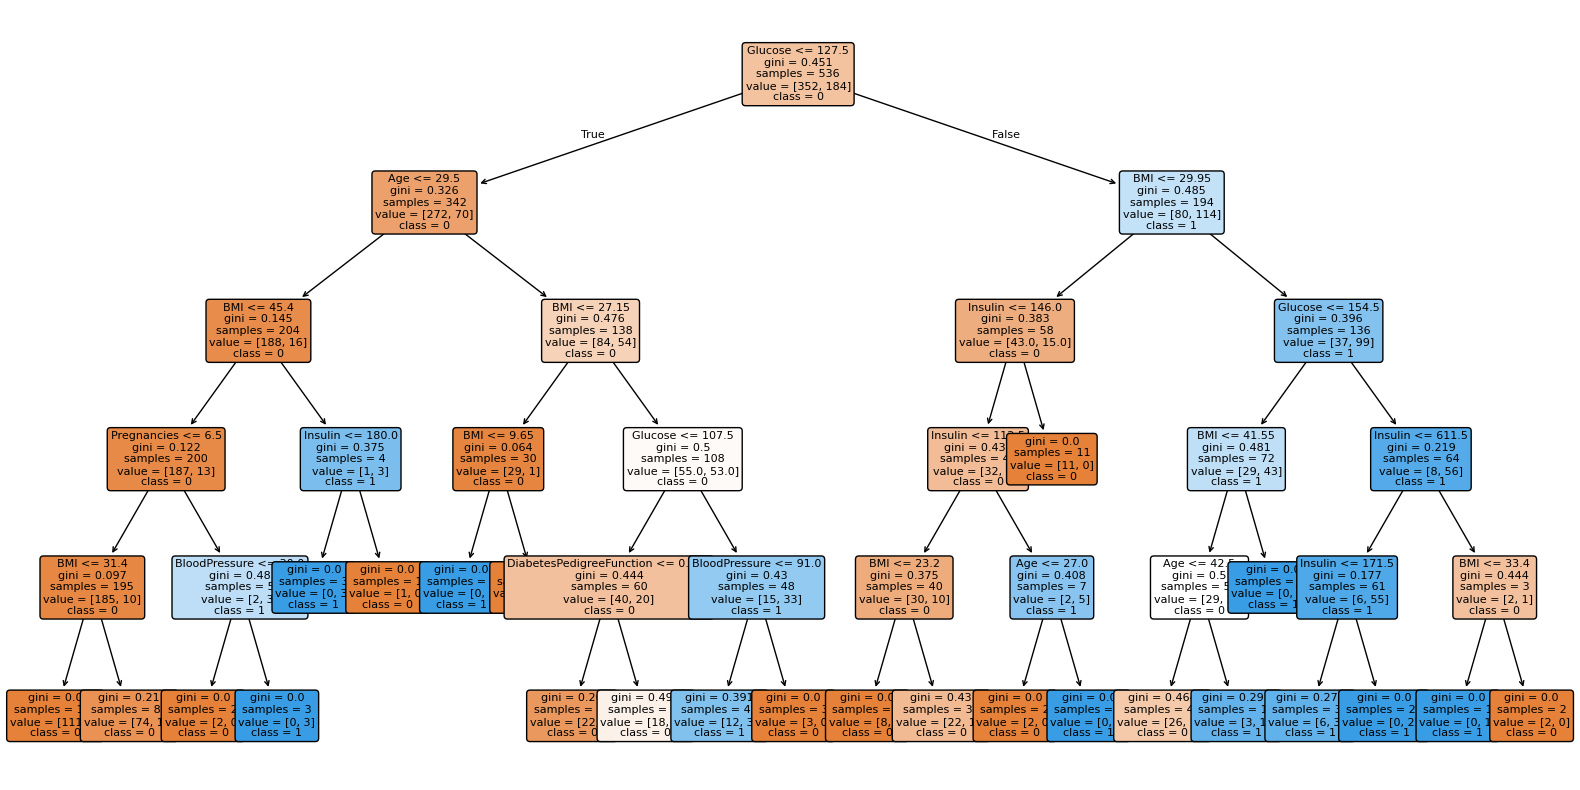

In [11]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, DecisionTreeClassifier

# Load the diabetes dataset
def load_data(url):
    dataset = pd.read_csv(url)
    return dataset

# ... (rest of your code remains the same)

# Main function
if __name__ == "__main__":
    # ... (your existing code)

    # Initialize and train a scikit-learn DecisionTreeClassifier
    sklearn_clf = DecisionTreeClassifier(max_depth=5)
    sklearn_clf.fit(X_train, y_train)

    # Extract feature names from the dataset
    feature_names = dataset.columns[:-1].tolist()

    # Plot the decision tree using the scikit-learn tree plotting function
    plt.figure(figsize=(20, 10))
    plot_tree(sklearn_clf,  # Use the scikit-learn classifier
              feature_names=feature_names,
              class_names=['0', '1'],
              filled=True,
              rounded=True,
              fontsize=8)
    plt.show()
